# Image segmentation

Extend your ResNet18 implementation to include a segmentation capabilities. The simplest extension of a backbone network is to simply generate the predictions at the last convolutional feature layer and then upsample them to fit the input image dimensions as described in https://arxiv.org/pdf/1411.4038.pdf (FCN-32s).

For this exercise you will be using the following dataset: https://www.kaggle.com/kumaresanmanickavelu/lyft-udacity-challenge - You don't have to download it from kaggle as it is already hosted on drive (the script to download it is a few cells down).

For this task, implement the FCN-32s (https://arxiv.org/pdf/1411.4038.pdf), however this is one of the first and simplest fully convolutional segmentation networks and the results will be coarse. You can optionally extend your network with more complex segmentation heads.

A few network architecture that you can optionally implement to improve the results:
- the full FCN network described in https://arxiv.org/pdf/1411.4038.pdf
- PSP-Net https://arxiv.org/pdf/1612.01105.pdf
- DeeplabV3 https://arxiv.org/pdf/1706.05587.pdf


Additionally, implement the U-Net architecture https://arxiv.org/pdf/1505.04597.pdf and use it as a segmentation network. Compare it to your FCN-32s implementation.



## Network implementation

In [14]:
import torch.nn as nn

class Block(nn.Module):

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        residual = x if self.downsample is None else self.downsample(x)
        out = self.relu1(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = self.relu2(out)
        return out

def Downsample(in_planes, planes, stride):
    return nn.Sequential(
        nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
        nn.BatchNorm2d(planes),
    )


class ResNet18FCN(nn.Module):

    def __init__(self, num_classes=13):
        super(ResNet18FCN, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = nn.Sequential(Block(in_planes = 64, planes = 64, stride = 1),
                                   Block(in_planes = 64, planes = 64, stride = 1))
        self.layer2 = nn.Sequential(Block(in_planes = 64, planes = 128, stride = 2, downsample = Downsample(64, 128, 2)),
                                   Block(in_planes = 128, planes = 128, stride = 1))
        self.layer3 = nn.Sequential(Block(in_planes = 128, planes = 256, stride = 2, downsample = Downsample(128, 256, 2)),
                                   Block(in_planes = 256, planes = 256, stride = 1))
        self.layer4 = nn.Sequential(Block(in_planes = 256, planes = 512, stride = 2, downsample = Downsample(256, 512, 2)),
                                   Block(in_planes = 512, planes = 512, stride = 1))

        self.conv_final = nn.Conv2d(512, num_classes, kernel_size=1, stride=1)
        self.upsample = nn.ConvTranspose2d(num_classes, num_classes, kernel_size = 32, stride = 32)


    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.conv_final(x)
        x = self.upsample(x)
        return x

In [15]:
class Block_UNet(nn.Module):
    def __init__(self, in_planes, planes):
        super(Block_UNet, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_planes, planes, kernel_size=3, padding=1),
            nn.BatchNorm2d(planes),
            nn.ReLU(inplace=True),
            nn.Conv2d(planes, planes, kernel_size=3, padding=1),
            nn.BatchNorm2d(planes),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class UNet(nn.Module):
    def __init__(self, in_planes, num_classes = 13):
        super(UNet, self).__init__()
        self.enc1 = Block_UNet(in_planes, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = Block_UNet(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = Block_UNet(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = Block_UNet(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = Block_UNet(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = Block_UNet(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = Block_UNet(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = Block_UNet(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = Block_UNet(128, 64)

        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):

        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        enc4 = self.enc4(self.pool3(enc3))
        bottleneck = self.bottleneck(self.pool4(enc4))
        dec4 = self.dec4(torch.cat((self.upconv4(bottleneck), enc4), dim=1))
        dec3 = self.dec3(torch.cat((self.upconv3(dec4), enc3), dim=1))
        dec2 = self.dec2(torch.cat((self.upconv2(dec3), enc2), dim=1))
        dec1 = self.dec1(torch.cat((self.upconv1(dec2), enc1), dim=1))

        return self.final_conv(dec1)



##Download the dataset
Download a part of the Lyft self driving dataset split into training and validation sets - https://www.kaggle.com/kumaresanmanickavelu/lyft-udacity-challenge


The dataset contains 13 classes:
0 - unlabeled,
1 - building,
2 - fence,
3 - other
4 - pedestrian,
5 - pole
6 - road line
7 - road
8 - sidewalk
9 - vegetation
10 - car
11 - wall
12 - traffic sign






In [11]:
#!pip install --upgrade --no-cache-dir gdown
#!gdown --id 1Mgxe0Nl19hxMhQqVvEpaRDNd_L_RaLNM
# if this link does not work try the other link
#!gdown --id 1wUFws0e5ArlYUg7NZiAjjrYOmTGCX_Fv
#!rm -r data
#!mkdir data
#!unzip -q seg_data.zip -d ./data/


from google.colab import drive
drive.mount('/content/drive')
!unzip -q ./drive/MyDrive/Colab/seg_data.zip

## Data loader

In [12]:
from torch.utils.data import Dataset
import glob
import cv2
import numpy as np

class SegmentationDataset(Dataset):

    def __init__(self, train=True):
        dataset_path = "./seg_data/" + ("train" if train else "test")
        self.images = sorted(glob.glob(dataset_path+"/*/*/CameraRGB/*.png"))
        self.masks = sorted(glob.glob(dataset_path+"/*/*/CameraSeg/*.png"))
        self.resize_shape = (320, 416)

    def __len__(self):
        return len(self.images)

    def transform_image(self, image_path, mask_path):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)[:,:,2]

        channels=3
        image = cv2.resize(image, dsize=(self.resize_shape[1], self.resize_shape[0]))
        mask = cv2.resize(mask, dsize=(self.resize_shape[1], self.resize_shape[0]))
        image = np.array(image).reshape((image.shape[0], image.shape[1], channels)).astype(np.float32) / 255.0
        mask = np.array(mask).reshape((image.shape[0], image.shape[1], 1))

        image = np.transpose(image, (2, 0, 1))
        mask = np.transpose(mask, (2, 0, 1))
        return image, mask

    def __getitem__(self, idx):
        image, mask = self.transform_image(self.images[idx], self.masks[idx])
        sample = {'image': image, "mask": mask, 'idx': idx}

        return sample

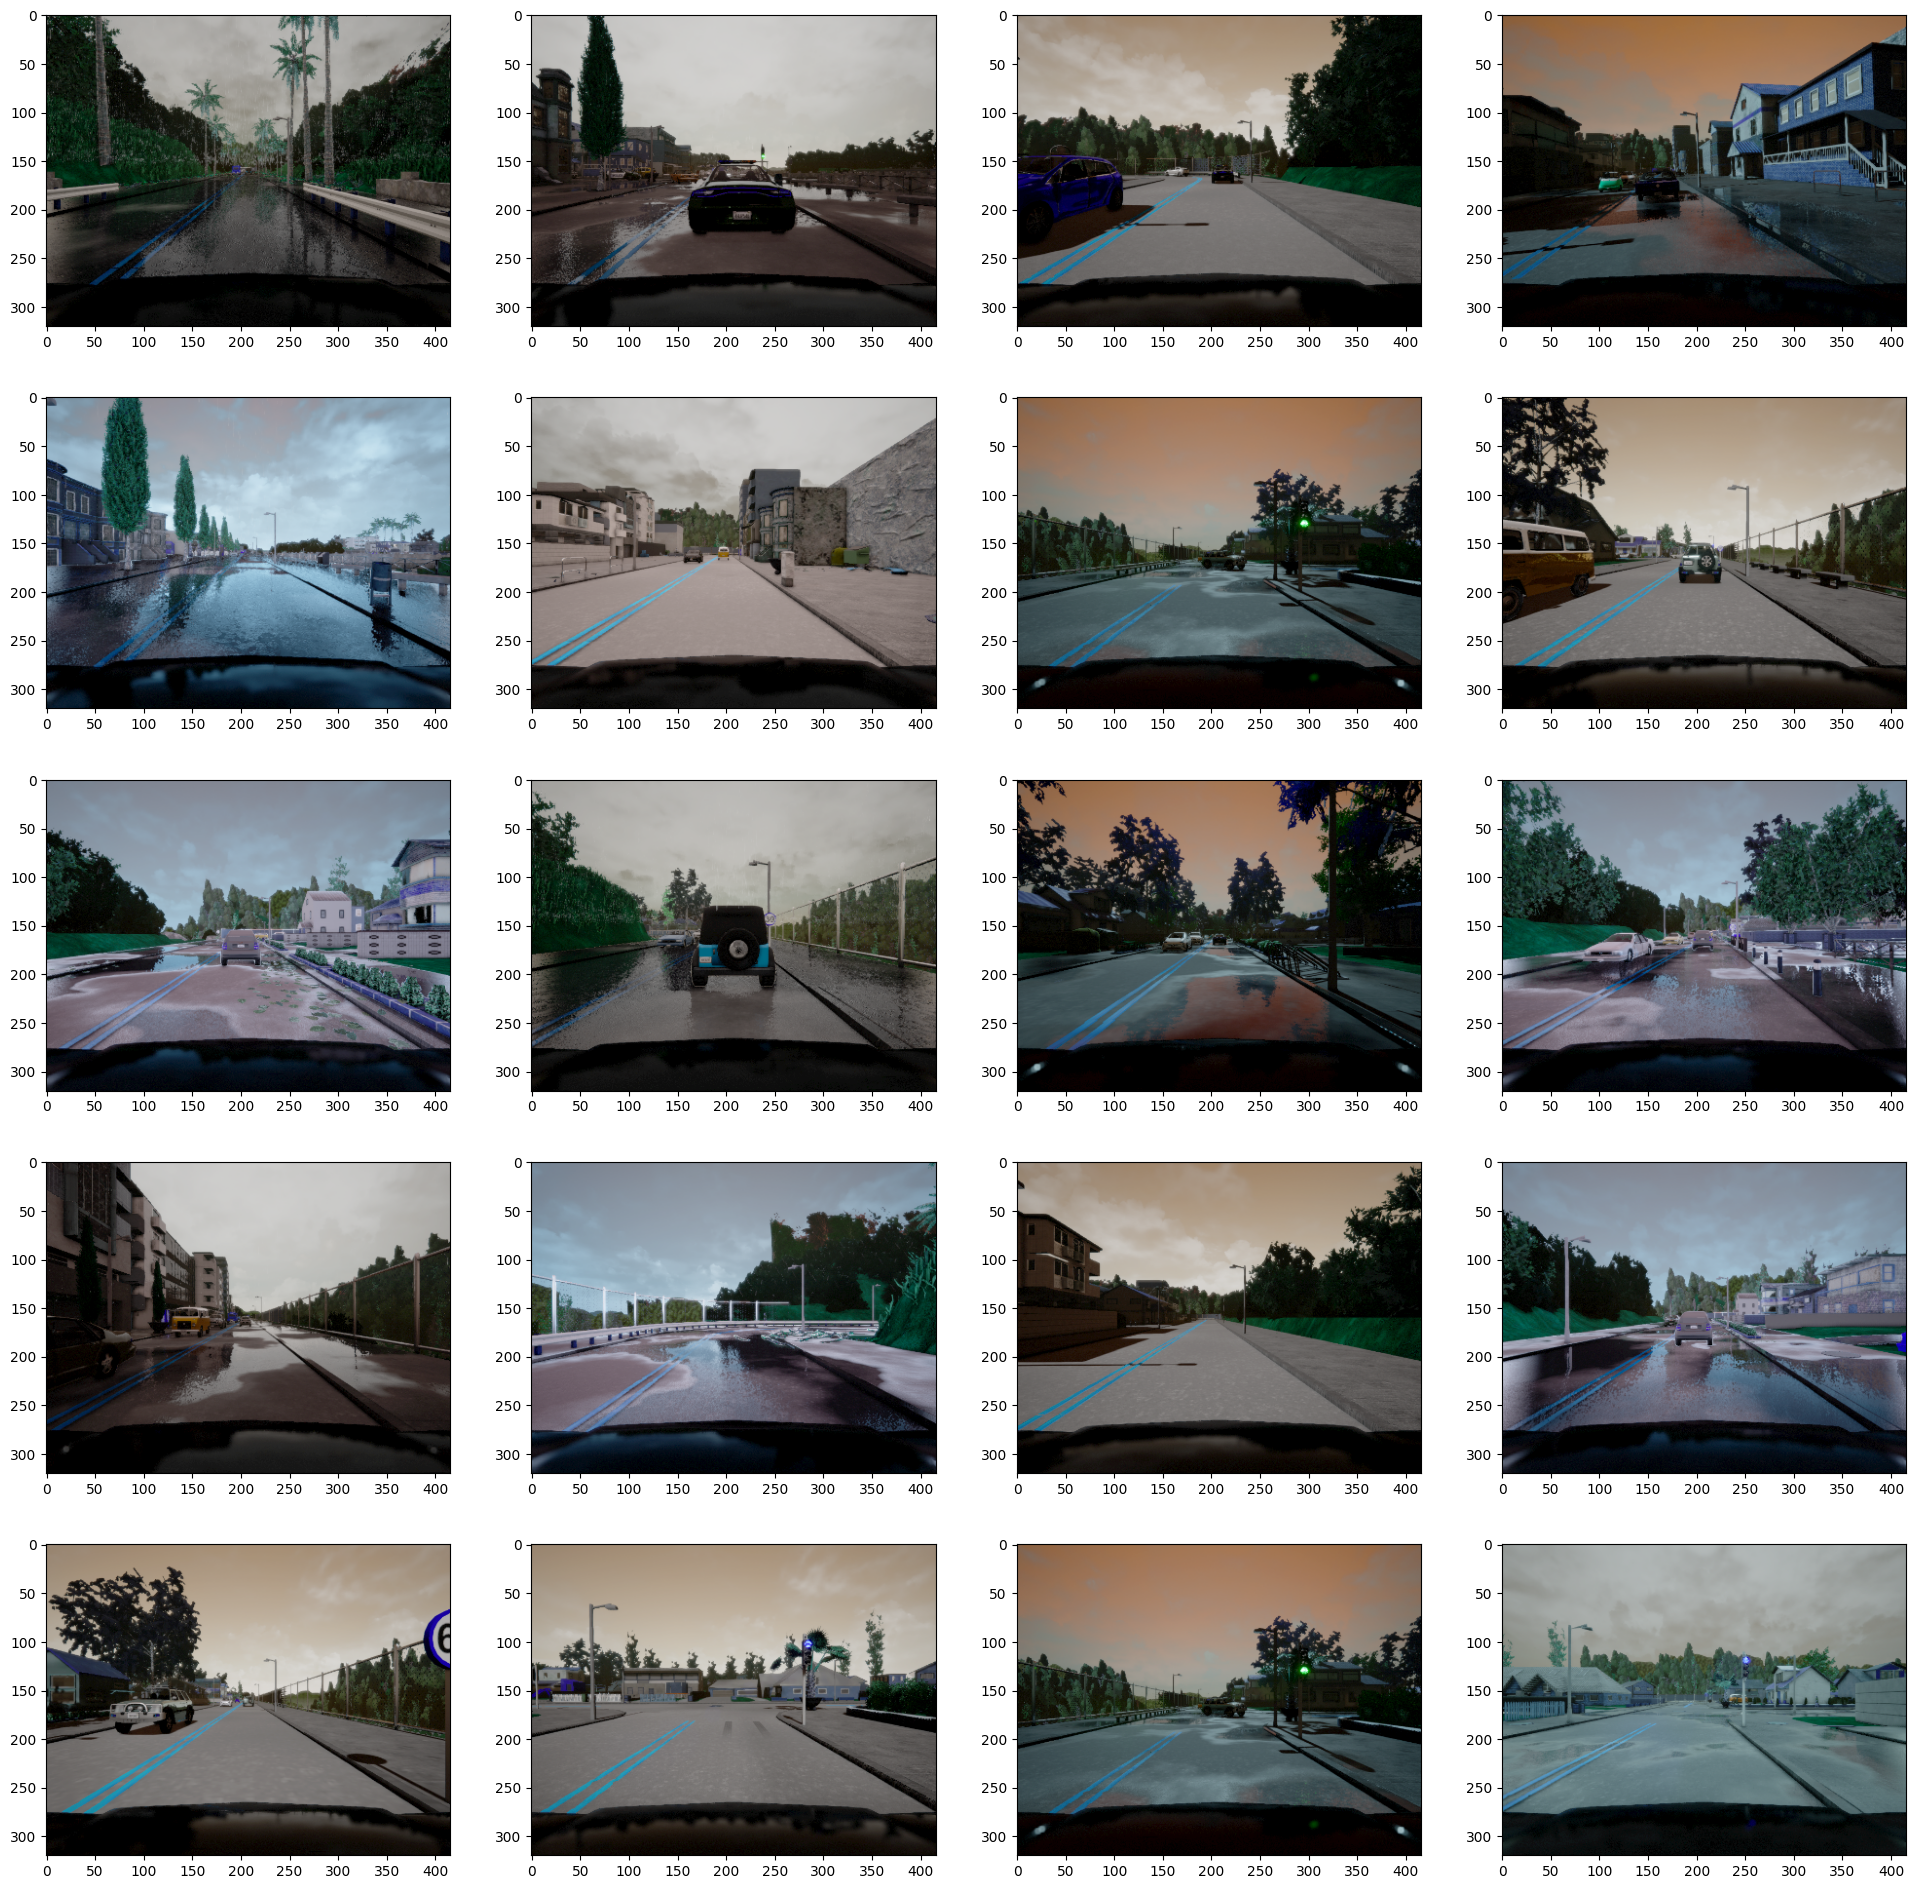

In [13]:
import torch
from tqdm.notebook import tqdm

trainset = SegmentationDataset(train=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = SegmentationDataset(train=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

import matplotlib.pyplot as plt
import numpy as np
fig=plt.figure(figsize=(24, 24))
columns = 4
rows = 5
for i in range(rows*columns):
  data = trainset[np.random.randint(len(trainset))]
  input = data["image"]
  label = data["mask"]
  img = input.transpose((1,2,0))
  ax = fig.add_subplot(rows, columns, i+1)
  plt.imshow(img)
plt.show()



In [16]:
import torch.optim as optim

net = UNet(in_planes=3, num_classes=13)
net.cuda()

# Define the loss function
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=0.0001)
epochs=2
for epoch in range(epochs):  # loop over the dataset multiple times
    with tqdm(total=len(trainset), desc =str(epoch)+"/"+str(epochs), miniters=int(50),unit='img') as prog_bar:
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs = data["image"]
          labels = data["mask"]
          inputs = inputs.cuda()
          labels = labels.cuda()

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels[:,0,:,:].long())
          loss.backward()
          optimizer.step()

          prog_bar.set_postfix(**{'loss': np.round(loss.data.cpu().detach().numpy(),5)})
          prog_bar.update(4)

0/2:   0%|          | 0/4000 [00:00<?, ?img/s]

1/2:   0%|          | 0/4000 [00:00<?, ?img/s]

In [17]:
resnet = ResNet18FCN()
resnet.cuda()

# Define the loss function
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(resnet.parameters(), lr=0.0001)
epochs=2
for epoch in range(epochs):  # loop over the dataset multiple times
    with tqdm(total=len(trainset), desc =str(epoch)+"/"+str(epochs), miniters=int(50),unit='img') as prog_bar:
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs = data["image"]
          labels = data["mask"]
          inputs = inputs.cuda()
          labels = labels.cuda()

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = resnet(inputs)
          loss = criterion(outputs, labels[:,0,:,:].long())
          loss.backward()
          optimizer.step()

          prog_bar.set_postfix(**{'loss': np.round(loss.data.cpu().detach().numpy(),5)})
          prog_bar.update(4)

0/2:   0%|          | 0/4000 [00:00<?, ?img/s]

1/2:   0%|          | 0/4000 [00:00<?, ?img/s]

## Visualize the results

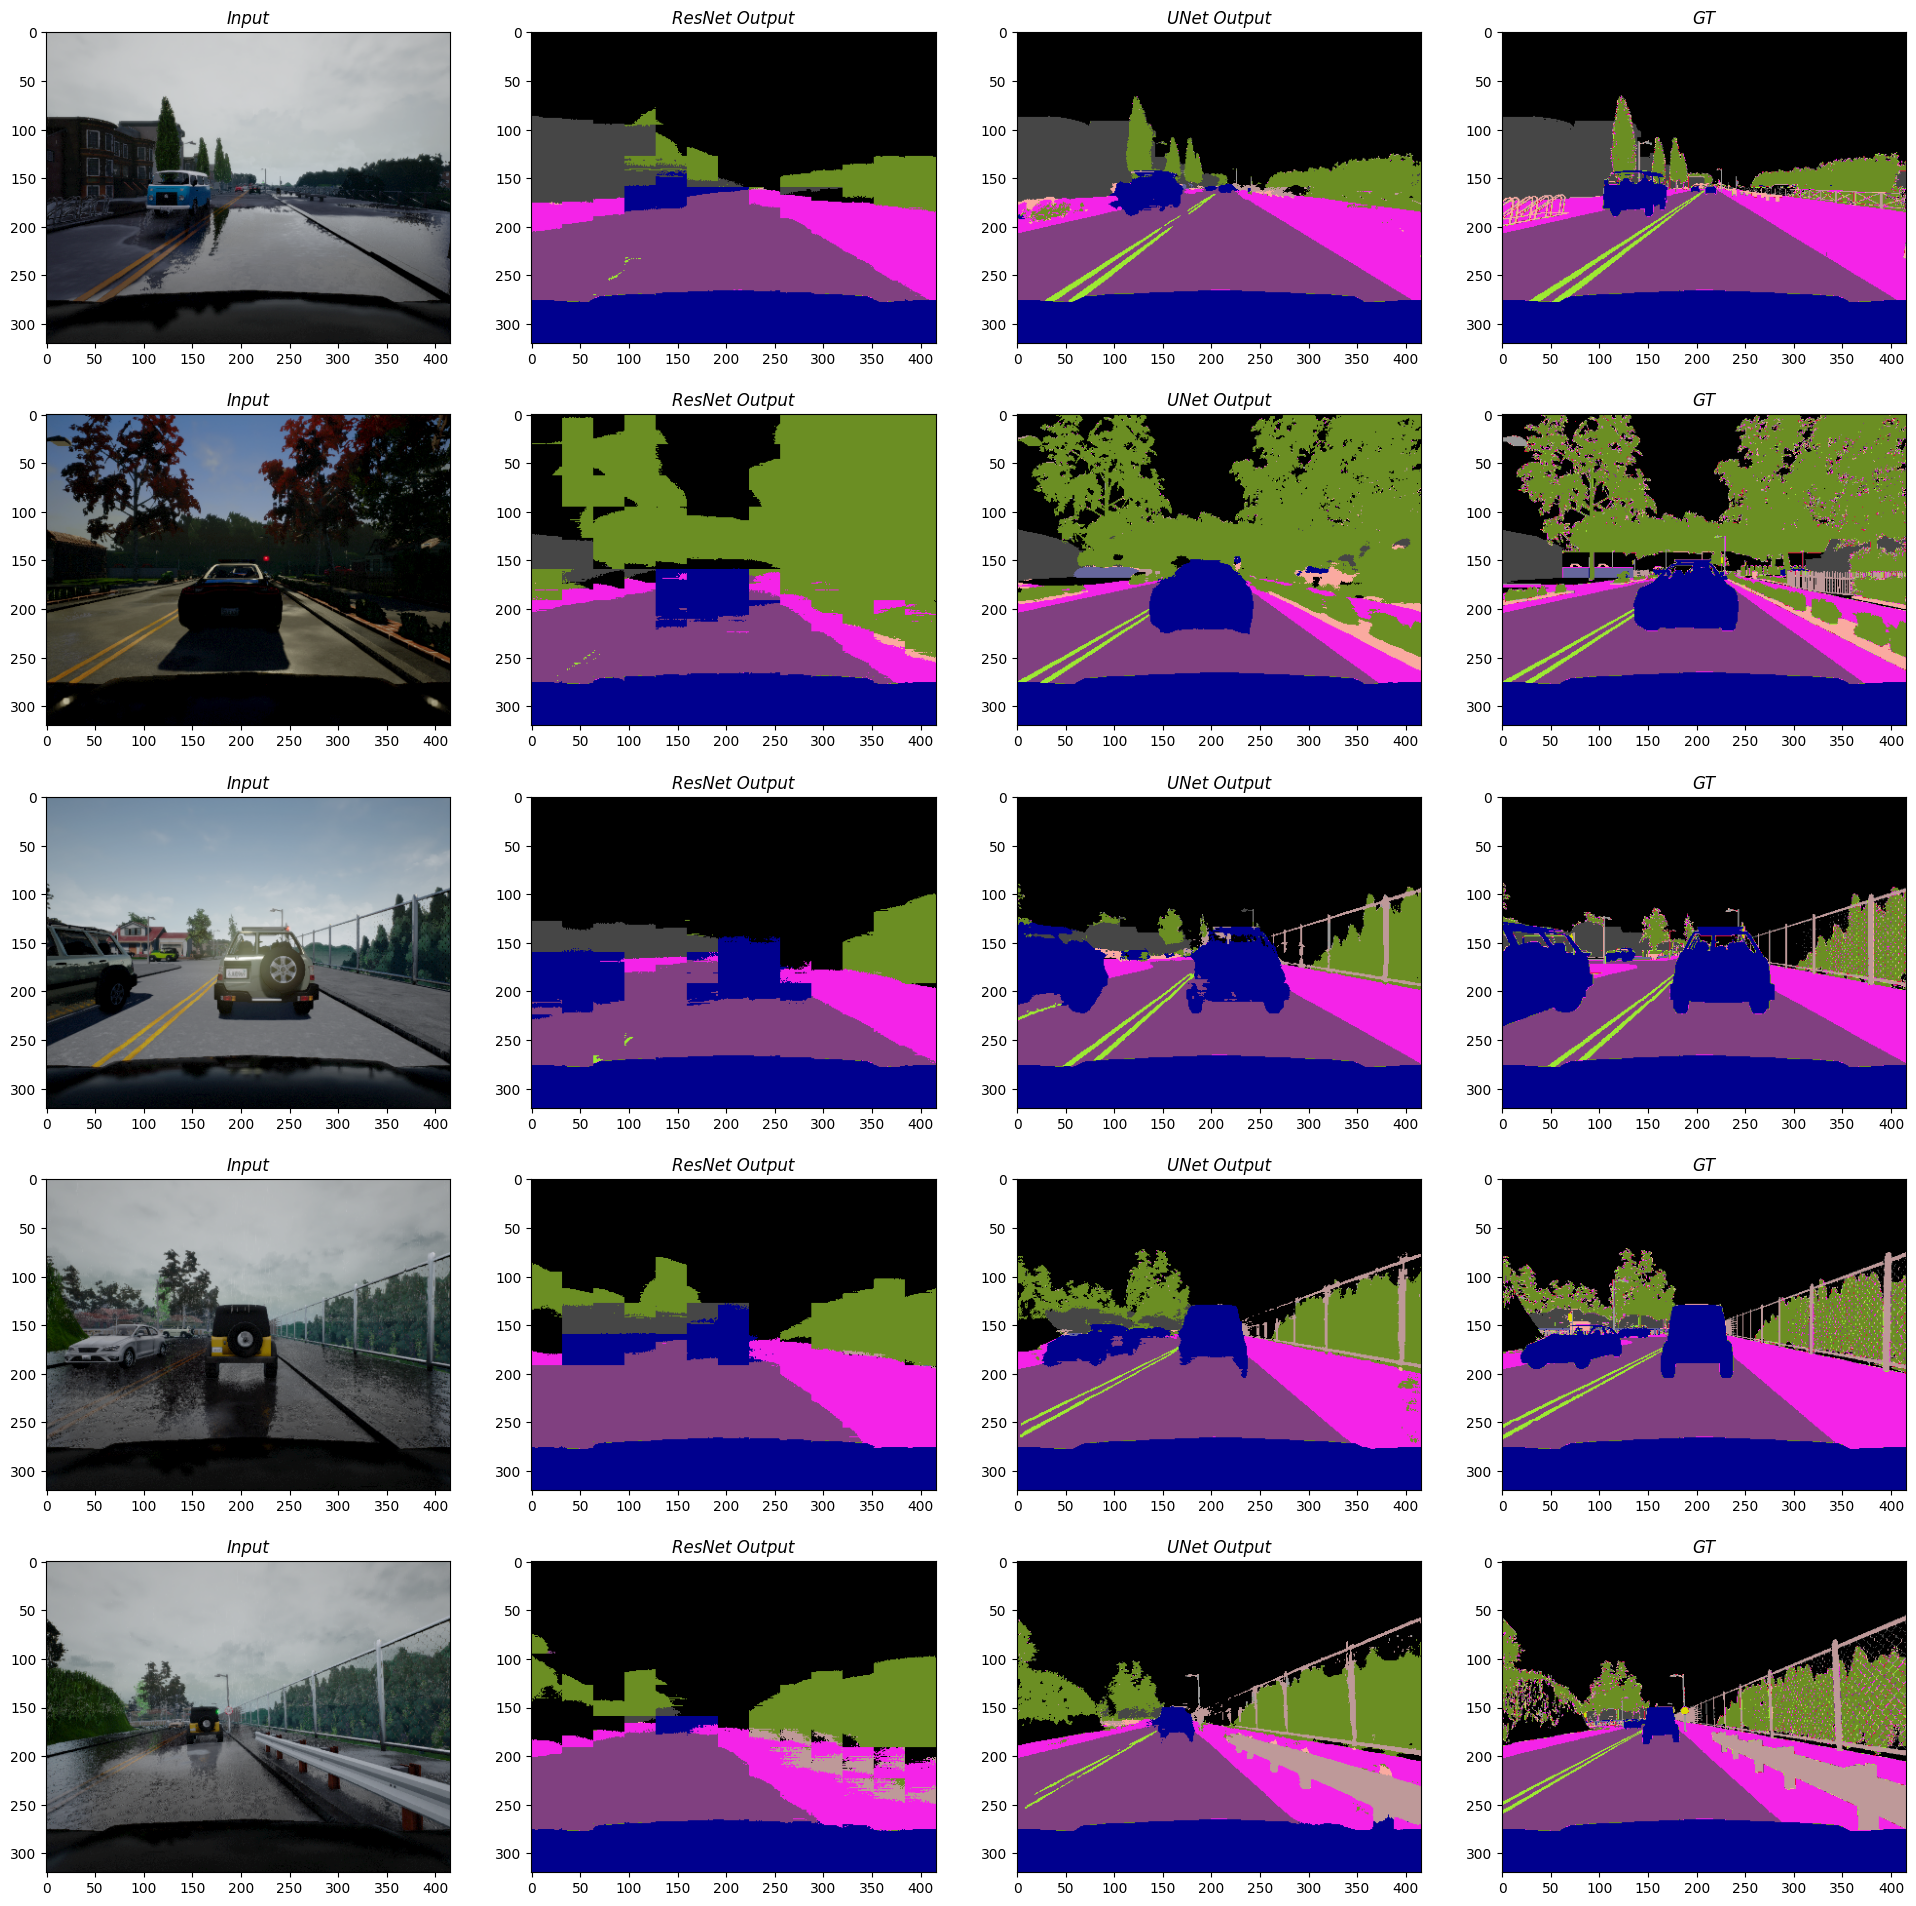

In [18]:
import matplotlib.pyplot as plt

label_colors = np.array([
[0,0,0], # unlabeled
[70,70,70], # building
[190,153,153], # fence
[250,170,160], # other
[220,20,60], # pedestrian
[153,153,153], # pole
[157,234,50], # road line
[128,64,128], # road
[244,35,232], # sidewalk
[107,142,35], # vegetation
[0,0,142], # car
[102,102,156], # wall
[220,220,0], # traffic sign
])


net.eval()
resnet.eval()


fig=plt.figure(figsize=(24, 24))
columns = 4
rows = 5
for i in range(rows):
  batch = testset[np.random.randint(len(testset))]
  img = batch['image']
  labels = batch['mask']
  img_tensor = torch.from_numpy(img).cuda()
  img_tensor = img_tensor.unsqueeze(0)

  # ResNet predictions
  outputs_resnet = resnet(img_tensor)
  out_image_resnet = outputs_resnet[0, :, :, :].detach().cpu().numpy()
  seg_mask_resnet = np.argmax(out_image_resnet, axis=0)
  seg_mask_color_resnet = label_colors[seg_mask_resnet]

  # UNet predictions
  outputs_unet = net(img_tensor)
  out_image_unet = outputs_unet[0, :, :, :].detach().cpu().numpy()
  seg_mask_unet = np.argmax(out_image_unet, axis=0)
  seg_mask_color_unet = label_colors[seg_mask_unet]

  # ground truth
  gt_mask_color = label_colors[labels[0,:,:]]

  img=img.transpose((1,2,0))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  labels = labels[0,:,:]

  # plotting
  ax = fig.add_subplot(rows, columns, i*columns+1)
  ax.set_title("Input", fontstyle='italic')
  plt.imshow(img)
  ax = fig.add_subplot(rows, columns, i*columns+2)
  ax.set_title("ResNet Output", fontstyle='italic')
  plt.imshow(seg_mask_color_resnet)
  ax = fig.add_subplot(rows, columns, i*columns+3)
  ax.set_title("UNet Output", fontstyle='italic')
  plt.imshow(seg_mask_color_unet)
  ax = fig.add_subplot(rows, columns, i*columns+4)
  ax.set_title("GT", fontstyle='italic')
  plt.imshow(gt_mask_color)

plt.show()

## Evaluate on the test set:

Implement the evaluation on the test set. Use the mean IOU metric to evaluate the result. - https://stackoverflow.com/questions/31653576/how-to-calculate-the-mean-iu-score-in-image-segmentation



In [43]:
def iou_per_class(pred, label, n_classes=13):
    ious = []
    for cls in range(n_classes):
        pred_inds = (pred == cls)
        label_inds = (label == cls)
        intersection = (pred_inds & label_inds).float().sum()
        union = (pred_inds | label_inds).float().sum()

        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(float(intersection) / max(union, 1))
    return ious

def mean_iou(iou_list):
    ious = [x for x in iou_list if not torch.isnan(torch.tensor(x))]
    return torch.mean(torch.tensor(ious))

In [32]:
resnet_iou_list = []
unet_iou_list = []

for i, data in enumerate(testset):
    img, true_mask = data['image'], data['mask']
    img = torch.from_numpy(img).unsqueeze(0).cuda()
    true_mask = torch.from_numpy(true_mask).cuda()

    # ResNet predictions
    resnet.eval()
    outputs_resnet = resnet(img)
    pred_mask_resnet = torch.argmax(outputs_resnet, dim=1)

    # UNet predictions
    net.eval()
    outputs_unet = net(img)
    pred_mask_unet = torch.argmax(outputs_unet, dim=1)

    # calculate IoUs
    resnet_iou = iou_per_class(pred_mask_resnet, true_mask)
    unet_iou = iou_per_class(pred_mask_unet, true_mask)

    resnet_iou_list.extend(resnet_iou)
    unet_iou_list.extend(unet_iou)

In [44]:
# calculate mean IoU
mean_iou_resnet = mean_iou(resnet_iou_list)
mean_iou_unet = mean_iou(unet_iou_list)

print(f'Mean IoU for ResNet: {mean_iou_resnet}')
print(f'Mean IoU for UNet: {mean_iou_unet}')

<ipython-input-43-f30d9b918726>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ious = [x for x in iou_list if not torch.isnan(torch.tensor(x))]


Mean IoU for ResNet: 0.3781591057777405
Mean IoU for UNet: 0.5231843590736389
